# Exploration-Exploitation in Reinforcement Learning

In this tutorial, we will implement the **UCBVI** algorithm, for exploration in MDPs with finite states and actions and a **finite horizon** criterion. In a finite horizon criterion, the value function of a policy is

$$V_h^{\pi}(s) = \mathbb{E}^{\pi}\left[\left.\sum_{\ell = h}^{H} \gamma^{\ell-h} r_{\ell} \right| s_h = s\right]$$

where the discount parameter $\gamma \in (0,1]$ is often set to $\gamma = 1$. 

### Useful libraries

In [1]:
# initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [2]:
# other useful imports
import numpy as np
import numba
import matplotlib.pyplot as plt
from copy import deepcopy
import gym
from rlberry.wrappers import DiscretizeStateWrapper
from gym.wrappers import Monitor

In [3]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

## Environment

Our goal is to learn a good policy in a Mountain Car environment. The Mountain Car environement as implemented in gym has a continuous state space. In order to apply UCBVI, we will discretize it (using a <a href="https://github.com/rlberry-py/rlberry/blob/main/rlberry/wrappers/discretize_state.py">wrapper from the rlberry library</a>).

In [4]:
def render(env, horizon=180,policy=None):
  """
  input  
  horizon : length of the simulation 
  policy : either a determinstic policy represented by an (H,S) array 
  or a random policy which is uniform (None)
  """
  env = deepcopy(env)
  env = Monitor(env, './gym_videos', force=True, video_callable=lambda episode: True)
  for episode in range(1):
    done = False
    state = env.reset()
    env.render()
    for hh in range(horizon):
        if policy is not None:
          action = policy[hh, state]
        else:
          action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        env.render()
    env.close()
    #show_video(directory='gym_videos')

In [6]:
#from rlberry.agents.mbqvi import MBQVIAgent

class MountainCatRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        if done:
            reward = 1.0
        else:
            reward = 0.0
        done = False 
        return next_state, reward, done, info

def get_mountain_car_env():
  env_with_continuous_states = MountainCatRewardWrapper(gym.make('MountainCar-v0'))
  env = DiscretizeStateWrapper(env_with_continuous_states, n_bins=10)
  return env

env = get_mountain_car_env()
render(env) #saves the video

INFO: Making new env: MountainCar-v0
INFO: Clearing 4 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /home/emilie/ownCloud/Cours Data Science/2021 2022/NotebookRL/gym_videos/openaigym.video.0.12361.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/home/emilie/ownCloud/Cours Data Science/2021 2022/NotebookRL/gym_videos')


In [7]:
X = env.discretized_states[0,:] # discretized positions
Xdot = env.discretized_states[1,:] # discretized velocities

test = 67

print(env.observation_space)
print(env.action_space)
print("state ",test," is ", (X[test],Xdot[test])) 
show_video(directory='gym_videos') # play the video

100-element Discrete space
Discrete(3)
state  67  is  (0.06000000238418579, 0.01400000005960464)


# Implementation of backward induction (i.e. value iteration)

In a finite-horizon MDP, the optimal Bellman equations given a recursion that can be used to compute the optimal value function. We have $V_{H+1}^\star(s) = 0$ for all $s$ and for $h \leq H$, 

$$Q^\star_h(s,a) = r(s,a) + \gamma \sum_{s' \in \mathcal{S}} p(s'|s,a) V^\star_{h+1}(s') \ \ \text{and } \ \ V^\star_{h}(s) = \max_{a \in \mathcal{A}} Q_h^\star(s,a).$$

Recall that the optimal policy is deterministic but *non-stationary* and satisfies $\pi^\star_h(s) = \text{argmax}_{a} Q^\star_h(s,a)$. 

**Complete the code below in order to compute the optimal Q function in a finite-horizon MDP.**

Note that this code will also be useful to compute the policy used in each episode by UCB-VI, where we have to perform Value Iteration in an optimistic MDP.

In [8]:
@numba.jit(nopython=True)  # use this to make the code much faster!

def backward_induction(P, R, H, gamma=1.0):
    """
    Parameters:
        P: transition function (S,A,S)-dim matrix
        R: reward function (S,A)-dim matrix
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        The optimal Q-function: array of shape (horizon, S,A)      
    """
    S, A = P.shape[0], P.shape[1]
    V = np.zeros((H + 1, S))
    Q = np.zeros((H+1,S,A))
    for h in range(H-1, -1, -1):
        for s in range(S):
            for a in range(A):
                Q[h,s,a] = R[s, a] + gamma * np.dot(P[s, a],  V[h + 1])
            # compute the value 
            V[h,s] = np.max(Q[h,s,:])
            # ... and clip it (needed later in UCB-VI)
            if (V[h, s] > H - h):
                V[h, s] = H - h
    return Q

We cannot try this function on the moutain car environement, as the expected rewards and transition probabilities cannot be easily computed, and are not embedded in the environment, unlike in our previous GridWorld example. 

So you can check your code on a simple gridworld. 

In [9]:
# Testing the implementation in a GridWorld
from rlberry.envs import GridWorld

test_env = GridWorld(nrows=8, ncols=8)
H = 50 # pick an horizon which is sufficient to reach the goal

Q_test = backward_induction(test_env.P,test_env.R,H,gamma=1.0)

state = test_env.reset()
test_env.enable_rendering()
for h in range(H):   
  action = np.argmax(Q_test[h, state,:])
  next_state, reward, is_terminal, info = test_env.step(action)
  if is_terminal:
    break
  state = next_state

# save video (run next cell to visualize it)
test_env.save_video('./videos/value_iteration_policy.mp4', framerate=10)
# clear rendering data
test_env.clear_render_buffer()
test_env.disable_rendering()


ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [10]:
# see video
show_video(filename='./videos/value_iteration_policy.mp4')

# Implementation of UCBVI

The UCBVI algorithm works as follows:

* In each episode $t$, the agent has observed $n_t$ transitions $(s_i, a_i, r_i, s_{i+1})_{i=1}^{n_t}$ of states, actions, rewards and next states.
* We estimate a model of the MDP as:
$$
\mathbf{rewards:}\quad\widehat{R}_t(s, a) = \frac{1}{N_t(s, a)} \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i)\} r_i
\\
\mathbf{transitions:}\quad \widehat{P}_t(s'|s, a) =  \frac{1}{N_t(s, a)} \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i, s'=s_{i+1}\} 
$$
where
$$
N_t(s, a) = \max\left(1, \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i)\} \right)
$$
* We define exploration bonuses as
$$
B_t(s, a) \propto \sqrt{\frac{1}{N_t(s, a)}} \cdot
$$

* Then, in episode $t$, we compute $\{Q_h^t(s, a)\}_{h=1}^H$ as the ($H$-horizon) optimal value functions in the MDP whose transitions are $\widehat{P}_t$ and whose rewards are $(\widehat{R}_t + B_t)$. At step $h$ of episode $t$, the agent chooses the action $a_h^t \in \arg\max_a Q_h^t(s, a)$.

In [11]:
# An example of bonus function
def bonus(N): 
    """input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.maximum(N, 1)
    return np.sqrt(1.0/nn)

# The UCB-VI algorithm
def UCBVI(env,H, nb_episodes,bonus_function=bonus,gamma=1):
    """
    Parameters:
        env: environement
        bonus_function : maps the number of visits to the corresponding bonus
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        episode_rewards: a vector storing the sum of rewards obtained in each episode 
        N_sa : array of size (S,A) giving the total number of visits in each state
        Rhat : array of size (S,A) giving the estimated average rewards
        Phat : array of size (S,A,S) giving the estimated transition probabilities
        optimistic_Q : array of size (H,S,A) giving the optimistic Q function used in the last episode     
    """
    S = env.observation_space.n
    A = env.action_space.n
    #policy = np.zeros((H, S), dtype=int)
    Phat = np.ones((S,A,S)) / S
    Rhat = np.zeros((S,A))
    N_sa = np.zeros((S,A), dtype=int) # number of visits
    
    N_sas = np.zeros((S,A,S), dtype=int) # number of transitions
    S_sa = np.zeros((S,A)) # cumulative rewards
    episode_rewards = np.zeros((nb_episodes,))
  
   
    for k in range(nb_episodes):
        sum_rewards = 0

        # compute the bonus for all states
        bonusses = bonus_function(N_sa)
        
        # run optimistic value iteration
        optimistic_Q = backward_induction(Phat, Rhat + bonusses, H,gamma)
        
        # execute policy
        initial_state = state = env.reset()
        for h in range(H):
            action = np.argmax(optimistic_Q[h,state,:])
            #print("action is ",action)
            next_state, reward, done, _ = env.step(action)

            sum_rewards += reward
            # update estimate
            N_sa[state, action] += 1
            N_sas[state, action, next_state] +=1
            S_sa[state, action] += reward
            Rhat[state, action] = S_sa[state, action]/N_sa[state, action]
            Phat[state, action, :] = N_sas[state, action, :]/N_sa[state, action]
            # go to next state
            state = next_state
            #print("state is ",state)
        
        # update sum of rewards
        episode_rewards[k] = sum_rewards
        
        if k % 50 == 0 or k==1:
            print("rewards in episode {}: {}".format(k, episode_rewards[k]), end = ", ")
            print("Number of visited states: ", (N_sa.sum(axis=1) > 0).sum() )
            # print(V[0, :])

    return episode_rewards, N_sa, Rhat, Phat,optimistic_Q

To check whether the algorithm is working, we can UCB-VI for a large number of episodes and monitor the amount of reward collected during the episode and the total number of visited states every 50 episodes. The algorithm should be improving, both in terms of maximizing rewards and in terms of exploration. 

In [12]:
NUM_REPETITIONS = 1
HORIZON = 180
NUM_EPISODES = 500

env = get_mountain_car_env()

rewards = np.zeros((NUM_REPETITIONS, NUM_EPISODES))
for sim in range(NUM_REPETITIONS):
    print(f"Running simulation: {sim}")
    rewards[sim], N_sa, Rhat, Phat, optimistic_Q = UCBVI(env, H=HORIZON, nb_episodes=NUM_EPISODES)

INFO: Making new env: MountainCar-v0


Running simulation: 0
rewards in episode 0: 0.0, Number of visited states:  4
rewards in episode 1: 0.0, Number of visited states:  6
rewards in episode 50: 25.0, Number of visited states:  79
rewards in episode 100: 38.0, Number of visited states:  81
rewards in episode 150: 42.0, Number of visited states:  82
rewards in episode 200: 12.0, Number of visited states:  83
rewards in episode 250: 25.0, Number of visited states:  83
rewards in episode 300: 43.0, Number of visited states:  83
rewards in episode 350: 37.0, Number of visited states:  83
rewards in episode 400: 66.0, Number of visited states:  83
rewards in episode 450: 0.0, Number of visited states:  83


# Evaluation of UCB-VI 

The theoretical guarantees for UCB-VI are in terms of regret, so the algorithm is aimed at collecting a large amount of rewards during learning. However, it can still provide a guess for the optimal policy and an estimate of its value.  

Two particular policies may be of interest: 
- the optimistic policy, which is the greedy policy wrt the optimistic Q-Value in the last episode 
- the empirical optimal policy, which is the optimal policy in the empirical MDP given by Rhat and P_hat

**Which one seems more interesting to you? For each policy, visualize how it behaves in the environment and display an estimate of the optimal value function. Comment on its shape.**

INFO: Clearing 4 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /home/emilie/ownCloud/Cours Data Science/2021 2022/NotebookRL/gym_videos/openaigym.video.1.12361.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/home/emilie/ownCloud/Cours Data Science/2021 2022/NotebookRL/gym_videos')


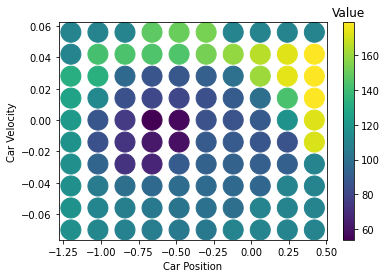

In [13]:
policy = np.argmax(optimistic_Q,axis=2)
render(env, HORIZON,policy)
show_video(directory='gym_videos')

value = np.max(optimistic_Q,axis=2)
plt.scatter(env.discretized_states[0, :], env.discretized_states[1, :], c=value[0, :], s=400)
plt.xlabel('Car Position')
plt.ylabel('Car Velocity')
clb=plt.colorbar()
clb.ax.set_title('Value')
plt.show()

UCB-VI is supposed to be good at maximizing rewards. Now we can display the total reward obtained in $k$ episodes as a function of the episode $k$ for different variants of UCB-VI, using different bonusses (e.g. a bonus closer to a theoretically-valid one, or no bonus at all) or a stupid uniform baseline. 

Note that unlike what we did for bandit algorithm, we cannot compute regret as we do not know the optimal value function for this problem. However, it may still be good to display average rewards over multiple simulations. 

**Display a cumulative rewards curve. What is a good bonus for this problem?**

# Going further

*On discount versus finite horizon.* In the previous practical sessions, we were finding an optimal policy wrt to a discounted notion of value. For a task like Mountain Car, all we care about is learning the policy that climbs up hill. We showed that choosing $H$ large enough in a finite horizon MDP does it. 

**What discount would you have chosen for a discounted-based algorithm?**  



*On the use of exploration bonus beyond UCB-VI.* Replacing rewards by rewards + a bonus that decays with the number of visits is a generic idea that can be transposed to any online reinforcement learning algorithm. 

**Would this idea make sense for the Fitted-Q algorithm? In what other algorithm(s) could you have done it?**

# Q-Learning with and without exploration

In [24]:
def QLearningExplo(env,H, nb_episodes,bonus_function=bonus,exp_proba = 0.05,gamma=1):
    S = env.observation_space.n
    A = env.action_space.n
    N_sa = np.zeros((S,A), dtype=int)  # number of visits
    N_hsa = np.zeros((H,S,A), dtype=int)  # number of visits in each step of the episode
    S_sa = np.zeros((S,A), dtype=int) # cumulative (true) rewards 
    N_sas = np.zeros((S,A,S), dtype=int) 
    
    Phat = np.ones((S,A,S)) / S # initialize estimated transitions and rewards 
    Rhat = np.zeros((S,A))
    
    episode_rewards = np.zeros((nb_episodes,))    
    
    Q = np.zeros((H+1,S,A)) # Q value
    
    for k in range(nb_episodes):
        sum_rewards =0
        state = env.reset()
        print("episode ",k)
        for h in range(H):
            print("step is",h)
            # choose an action with epsilon-greedy
            action = np.argmax(Q[h,state])
            if (np.random.rand()<exp_proba):
                action = env.action_space.sample()
            # perform the transition 
            new_state,reward,done,_=env.step(action)
            opt_reward = reward + bonus_function(N_sa[state,action])
            # update visits
            N_sa[state,action]+=1
            N_hsa[h,state,action]+=1
            N_sas[state,action,new_state]+=1
            S_sa[state,action]=+reward
            sum_rewards+= rewards
            # update MDP parameter 
            Phat[state,action,:] = N_sas[state,action,:]/N_sa[state,action]
            Rhat[state,action] = S_sa[state,action]/N_sa[state,action]
            # update Q-function 
            Q[h,state,action]+= (1/N_hsa[h,state,action])*(opt_reward + gamma*np.max(Q[h+1,new_state]) - Q[h,state,action])
            # update state 
            state = new_state
        
        episode_rewards[k]=sum_rewards
        
        if k % 50 == 0 or k==1:
            print("rewards in episode {}: {}".format(k, episode_rewards[k]), end = ", ")
            print("Number of visited states: ", (N_sa.sum(axis=1) > 0).sum() )
         
    return episode_rewards, N_sa, Rhat, Phat,Q
    
            


In [ ]:
rewards, N_sa, Rhat, Phat, Q_learn = QLearningExplo(env, H=HORIZON, nb_episodes=2*NUM_EPISODES)
print(rewards)

episode  0
step is 0
step is 1
step is 2
step is 3
step is 4
step is 5
step is 6
step is 7
step is 8
step is 9
step is 10
step is 11
step is 12
step is 13
step is 14
step is 15
step is 16
step is 17
step is 18
step is 19
step is 20
step is 21
step is 22
step is 23
step is 24
step is 25
step is 26
step is 27
step is 28
step is 29
step is 30
step is 31
step is 32
step is 33
step is 34
step is 35
step is 36
step is 37
step is 38
step is 39
step is 40
step is 41
step is 42
step is 43
step is 44
step is 45
step is 46
step is 47
step is 48
step is 49
step is 50
step is 51
step is 52
step is 53
step is 54
step is 55
step is 56
step is 57
step is 58
step is 59
step is 60
step is 61
step is 62
step is 63
step is 64
step is 65
step is 66
step is 67
step is 68
step is 69
step is 70
step is 71
step is 72
step is 73
step is 74
step is 75
step is 76
step is 77
step is 78
step is 79
step is 80
step is 81
step is 82
step is 83
step is 84
step is 85
step is 86
step is 87
step is 88
step is 89
step is 9

In [ ]:
policy = np.argmax(Q_learn,axis=2)
render(env, HORIZON,policy)
show_video(directory='gym_videos')
